# STEP 1 : DATA PREPROCESSING

#### importng python libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

#### load the data

In [2]:
df = pd.read_csv('customer.csv')

#### drop un-usefull values

In [3]:
df = df.drop(['Client_Num', 'Zipcode'], axis=1)

#### convert binory columns to 0/1

In [4]:
binary_cols = ['Car_Owner', 'House_Owner', 'Personal_loan']
df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})

C:\Users\Admin\AppData\Local\Temp\ipykernel_11364\2489440696.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})


#### encode catagorical variable

In [5]:
cat_cols = ['Gender', 'Education_Level', 'Marital_Status', 'state_cd', 'contact', 'Customer_Job']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#### handle missing values if any

In [6]:
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

#### seperate features and targets

In [7]:
X = df.drop('Personal_loan', axis=1)
y = df['Personal_loan']

#### splite data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### scale numerical features

In [9]:
scaler = StandardScaler()
num_cols = ['Customer_Age', 'Dependent_Count', 'Income', 'Cust_Satisfaction_Score']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# STEP 2: MODEL BUILDING

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


#### handle class imbalance

In [13]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


#### initialize and train model

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

#### predictions

In [15]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC

#### evaluation

In [16]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[2492  151]
 [ 360   30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.91      2643
           1       0.17      0.08      0.11       390

    accuracy                           0.83      3033
   macro avg       0.52      0.51      0.51      3033
weighted avg       0.78      0.83      0.80      3033


ROC AUC Score: 0.5089302172162559


# STEP 3 : FEATURE IMPORTANCE ANALYSIS

In [17]:
import matplotlib.pyplot as plt


#### get feature importance

In [18]:
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

#### plot

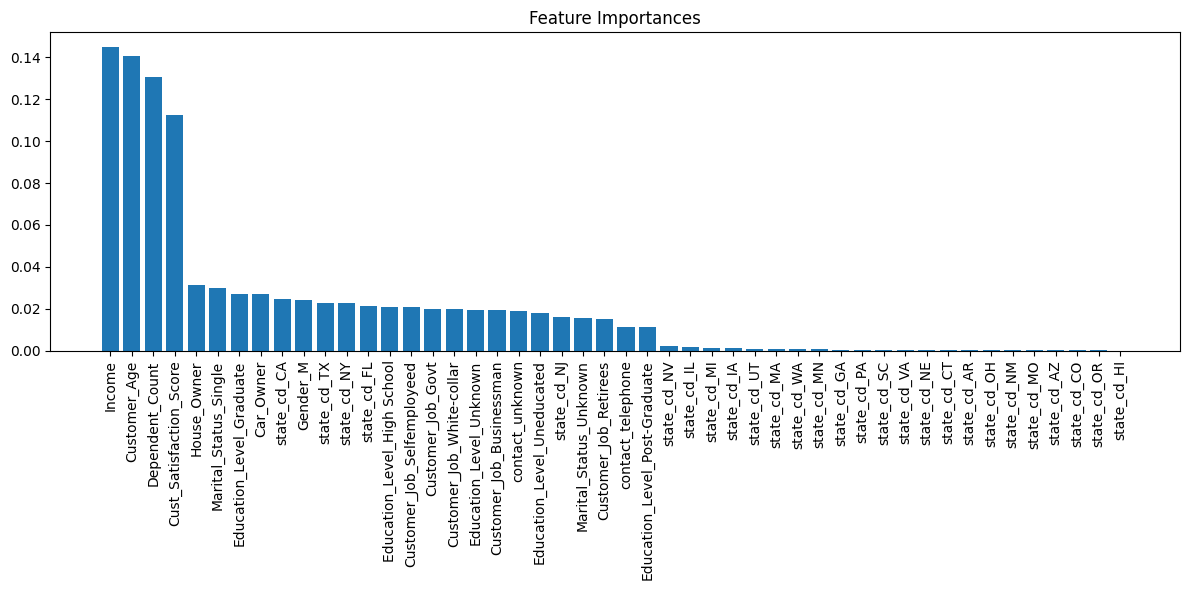

In [19]:
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# STEP 4 : MODEL OPTIMIZATION

In [20]:
from sklearn.model_selection import GridSearchCV

#### define paramrter grid

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


#### grid search

In [22]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                         param_grid, 
                         cv=5, 
                         scoring='roc_auc',
                         n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')